In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import sys
sys.path.insert(0, "/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner")
from utils import run_inference, plot_cross_label_heatmap, plot_score_stacked_bar, plot_score_violin

/mnt/public3/caogs/anaconda3/envs/deepseek/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reasoning_mode = False
eval_file_path = "/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/output/pbmc_demo_for_CellReasoner.json"
data_name = os.path.basename(eval_file_path).split('.')[0].replace('_for_CellReasoner', '')
out_path = "/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/output"
has_label = True


In [3]:
test_df =  pd.read_json(eval_file_path)

In [4]:
model_name = "guangshuo/CellReasoner-7B"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",    
    output_hidden_states=True,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", 
    trust_remote_code=True
    )
tokenizer = AutoTokenizer.from_pretrained(model_name)

/mnt/public3/caogs/anaconda3/envs/deepseek/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


In [5]:
output_data = run_inference(
    model=model,
    tokenizer=tokenizer,
    data=test_df,  # DataFrame with columns: input, instruction, cell_name, (optional) output
    batch_size=4, #GTX 4090 recommend 4
    log_interval=2,
    reasoning_mode=False,
    has_label=True
)


Processing batch 1/9
Processing batch 3/9
Processing batch 5/9
Processing batch 7/9
Processing batch 9/9
Inference finished.


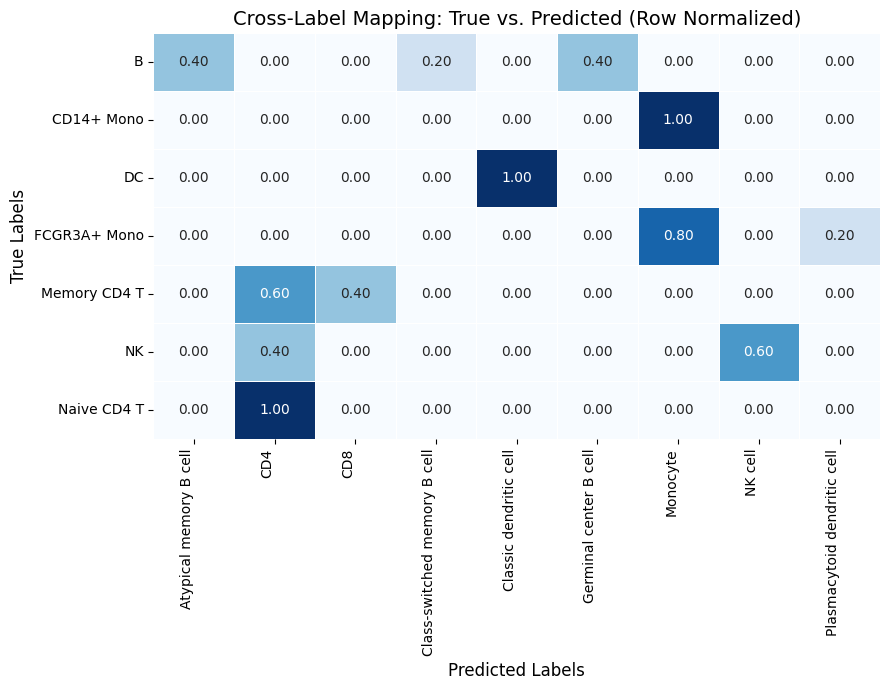

In [6]:
output_data_df = pd.DataFrame(output_data)
plot_cross_label_heatmap(output_data_df,'labels', 'response', normalize=True)

In [7]:
pair_score_path = "/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/data/all_pair_score.xlsx"
pair_score = pd.read_excel(pair_score_path, engine='openpyxl')


In [8]:
output_data_df = output_data_df.merge(pair_score, how='left', left_on=["labels", "response"], right_on=["Ground Truth", "Model Prediction"]).drop(columns=["Ground Truth", "Model Prediction"])

/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:207: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  ax = sns.violinplot(
/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


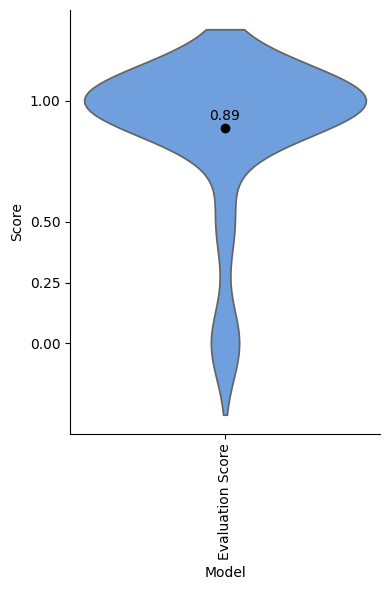

/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:397: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_height = bottom[i]
/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:404: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_height = bottom[i]
/public/workspace/caoguangshuo/public6/Pancancer/cancerGPT/CellReasoner/utils.py:413: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


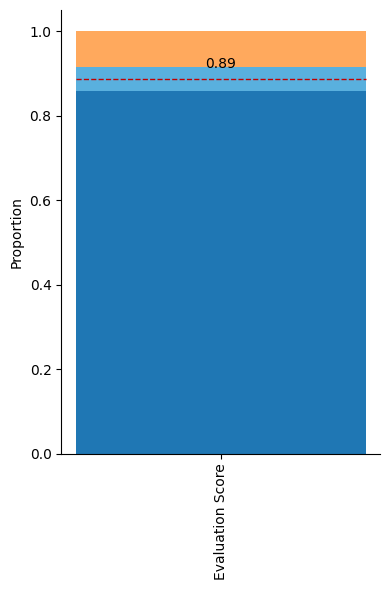

In [9]:
plot_score_violin(output_data_df,fig_size=(4, 6))
plot_score_stacked_bar(output_data_df, fig_size=(4, 6))

In [10]:
# Reasoning mode

In [11]:
output_data = run_inference(
    model=model,
    tokenizer=tokenizer,
    data=test_df, 
    batch_size=2, #GTX 4090 recommend 2
    log_interval=2,
    reasoning_mode=True,
    has_label=True
)
output_data_df = pd.DataFrame(output_data)

Processing batch 1/18
Processing batch 3/18
Processing batch 5/18
Processing batch 7/18
Processing batch 9/18
Processing batch 11/18
Processing batch 13/18
Processing batch 15/18
Processing batch 17/18
Inference finished.


In [12]:
output_data_df

,cell_name,response,labels
0,ACCGTGCTGGAACG,"First, I need to recall what each gene does a...",B
1,ACGTGATGCCATGA,Now let's tackle this long list of genes.\n\n...,DC
2,AGCGATTGAGATCC,Now I need to analyze the user-provided gene ...,NK
3,AGCGGGCTTGCCAA,"First, I need to identify which of these gene...",Naive CD4 T
4,AGGTCTGATTCTCA,Now let's tackle this long list step by step....,FCGR3A+ Mono
5,AGTACTCTCGGTAT,Now let's tackle this long list of genes. The...,Memory CD4 T
6,ATACGGACTATGCG,Now let's tackle this problem step by step.\n...,B
7,ATCTTTCTTGTCCC,Now let's tackle this long list of genes. The...,NK
8,CAAAGCACCGTAAC,"First, I need to recall what each gene does a...",B
9,CCCTAGTGCAAAGA,Now let's tackle this long list of genes.\n\n...,Memory CD4 T


In [13]:
print(output_data_df['response'].iloc[0])

 First, I need to recall what each gene does and in which cell types they're typically expressed.

CD74 and HLA genes (like HLA-DRA, HLA-DRB1) are involved in antigen presentation, so that's a clue for B-cells or other immune cells. MS4A1 is CD20, a classic B-cell marker. CD79A and CD79B are components of the B-cell receptor complex. So this is definitely a B-cell related tumor.

Looking at other markers: LTB (lymphotoxin beta), which is involved in lymphoid organ development. BANK1 is associated with B-cell activation. SPIB is a transcription factor important in B-cell differentiation. PTPRC (CD45) is a common leukocyte marker but not specific to B-cells. However, the presence of multiple B-cell markers like CD79A/B, MS4A1, CD19 (though not listed here, maybe other markers compensate), suggests it's a B-cell malignancy.

Now, considering different B-cell tumors: Diffuse large B-cell lymphoma (DLBCL) has subtypes, some of which might express these markers. Germinal center B-cell (GCB) 